In [1]:
from ingestion import make_cleaned, make_train_test
from metadata_helpers import save_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error
# RandomForest is a combination of bootstrap sampling and randomized feature selection at each split.
# It de-correlates the individual trees in the ensemble beyond what bagging does.


In [2]:
X_train, X_test, y_train, y_test = make_train_test()

categoric_cols = X_train.select_dtypes(include=object).columns.tolist()
OH_encoder = SklearnTransformerWrapper(transformer=OneHotEncoder(
    sparse_output=False, drop='if_binary', min_frequency=0.1, handle_unknown='ignore'), variables=categoric_cols)
pipe = make_pipeline(OH_encoder, RandomForestRegressor(
    oob_score=False, n_jobs=6, random_state=42))
num_trees_range = [100, 250, 400]
fraction_features = np.linspace(0.1, 1.0, num=4)
fraction_samples = [1.0]  # determined from previous grid search
depth_range = [4, 7, 9, 11]
gs = GridSearchCV(n_jobs=3, estimator=pipe, cv=10,
                  scoring='neg_root_mean_squared_error', param_grid={'randomforestregressor__n_estimators': num_trees_range,
                                                                     'randomforestregressor__max_features': fraction_features, 'randomforestregressor__max_samples': fraction_samples, 'randomforestregressor__max_depth': depth_range})


In [3]:
gs.fit(X_train, y_train)


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sklearntransformerwrapper',
                                        SklearnTransformerWrapper(transformer=OneHotEncoder(drop='if_binary',
                                                                                            handle_unknown='ignore',
                                                                                            min_frequency=0.1,
                                                                                            sparse_output=False),
                                                                  variables=['MSSubClass',
                                                                             'MSZoning',
                                                                             'Street',
                                                                             'Alley',
                                                                             'LotShape',
                                                                             'LandContour',
                                                                             'Utilities',
                                                                             'LotConfig',
                                                                             'LandSlope',
                                                                             'Neighborhood',
                                                                             'Condition1',
                                                                             'Co...
                                                                             'PavedDrive', ...])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=6,
                                                              random_state=42))]),
             n_jobs=3,
             param_grid={'randomforestregressor__max_depth': [4, 7, 9, 11],
                         'randomforestregressor__max_features': array([0.1, 0.4, 0.7, 1. ]),
                         'randomforestregressor__max_samples': [1.0],
                         'randomforestregressor__n_estimators': [100, 250,
                                                                 400]},
             scoring='neg_root_mean_squared_error')

In [4]:
gs.best_params_


{'randomforestregressor__max_depth': 11,
 'randomforestregressor__max_features': 0.4,
 'randomforestregressor__max_samples': 1.0,
 'randomforestregressor__n_estimators': 400}

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/en

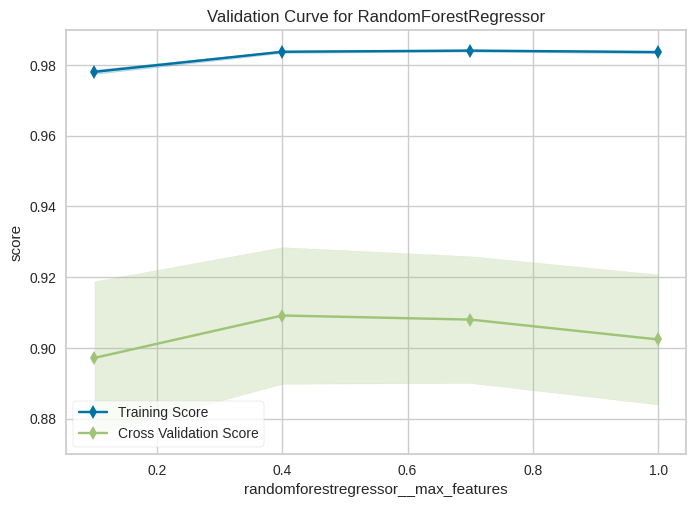

<AxesSubplot: title={'center': 'Validation Curve for RandomForestRegressor'}, xlabel='randomforestregressor__max_features', ylabel='score'>

In [5]:
pipe_validation = make_pipeline(OH_encoder, RandomForestRegressor(
    oob_score=False, n_jobs=6, random_state=42, max_samples=1.0, n_estimators=400, max_depth=11))
viz = ValidationCurve(
    pipe_validation, cv=10, param_name='randomforestregressor__max_features', param_range=fraction_features
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


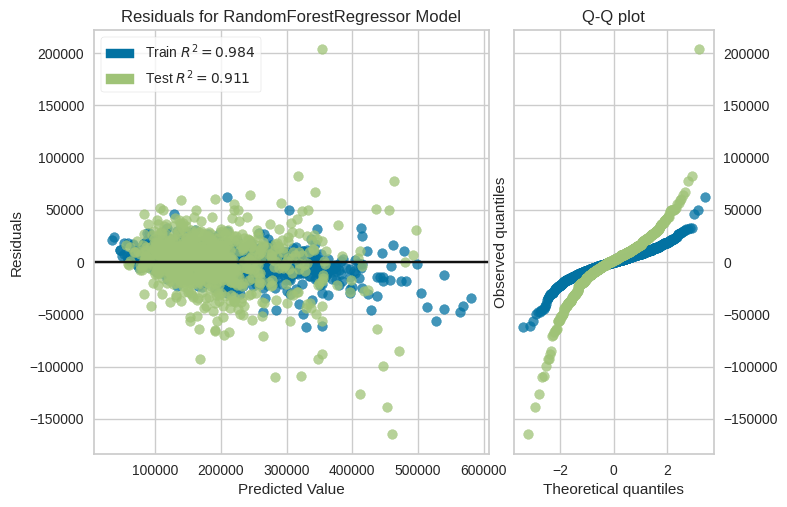

<AxesSubplot: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [6]:
pipe_final = make_pipeline(OH_encoder, RandomForestRegressor(
    oob_score=False, n_jobs=6, random_state=42, max_samples=1.0, n_estimators=400, max_depth=11, max_features=0.4))
visualizer = ResidualsPlot(pipe_final, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [7]:
rmse_test = mean_squared_error(
    pipe_final.predict(X_test), y_test, squared=False)
print(f"rmse = {rmse_test}")


rmse = 23584.894381310944


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [8]:
save_score(pipe_final, rmse_test)